0. Install necessary libraries and packages for this project

In [77]:
import spuco.datasets as dsets
from spuco.datasets.base_spuco_dataset import SpuriousFeatureDifficulty
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, Sampler
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import random

Use default parameters to initialize dataset; parameters found using SpuCo documentation, and made a separate class for each digit; transformed data into tensors so it could work with our neural network

In [78]:
# 0. Use default parameters to initialize dataset
classes = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_LARGE
transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor()
])
dataset = dsets.spuco_mnist.SpuCoMNIST(
    root="data/mnist/",
    spurious_feature_difficulty=difficulty,
    classes=classes,
    spurious_correlation_strength=0.5, # High spurious correlation; want to train model to not rely on these spurious features
    transform=transform
)
dataset.initialize()

100%|██████████| 48004/48004 [00:02<00:00, 23620.12it/s]


2. Train a model using ERM
# Choose hyperparameters carefully and choose the model with the least average of the loss function for ERM

In [80]:
# Split data into training, testing, validation and create data loaders for training and validation data
total_size = len(dataset)
train_size = int(0.7 * total_size)
validation_size = int(0.15 * total_size)
test_size = total_size - train_size - validation_size
train_data, validation_data, test_data = random_split(dataset, [train_size, validation_size, test_size])
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)
# Get device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Build a CNN model for our ERM training
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*3*3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        # Input: 3x28x28, output: 32x14x14
        x = self.pool(F.relu(self.conv1(x)))
        # Input: 32x14x14, output: 64x7x7
        x = self.pool(F.relu(self.conv2(x)))
        # Input: 64x7x7, output: 128x3x3
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128*3*3) # Flatten tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Now, we can train our model using ERM with our dataloaders along with our model, loss function, and optimizer.

In [81]:
# Train our model with ERM; choose model, loss function, and optimizer
epochs = 5
lr = 1e-3
model = CNNModel().to(device)
def train_erm(epochs, lr, model, train_dataloader, validation_dataloader, loss_fn = nn.CrossEntropyLoss(), optimizer_func = torch.optim.Adam):
    optimizer = optimizer_func(model.parameters(), lr)
    # Training our model
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_dataloader)

        # Evaluate on validation data
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad(): # Disable gradient calculation
            for images, labels in validation_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_validation_loss = validation_loss / len(validation_dataloader)
        validation_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_validation_loss}, Val Acc: {validation_accuracy}%')

train_erm(5, 1e-3, model, train_dataloader, validation_dataloader)

Epoch [1/5], Train Loss: 0.8588113820471021, Val Loss: 0.1252320401898, Val Acc: 96.08333333333333%
Epoch [2/5], Train Loss: 0.1256741406703807, Val Loss: 0.08480840074145689, Val Acc: 97.29166666666667%
Epoch [3/5], Train Loss: 0.08735402149990194, Val Loss: 0.06419755226676971, Val Acc: 97.79166666666667%
Epoch [4/5], Train Loss: 0.06299901456738549, Val Loss: 0.054501830228291186, Val Acc: 98.33333333333333%
Epoch [5/5], Train Loss: 0.047181045701133024, Val Loss: 0.059397112304114, Val Acc: 98.20833333333333%


2. Cluster inputs based on the output they produce for ERM

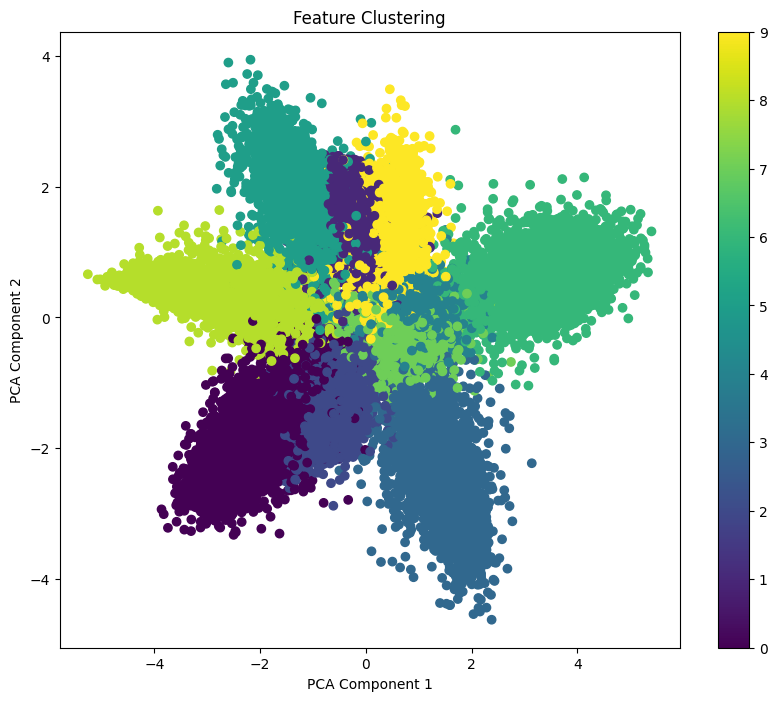

In [82]:
# 2. Cluster inputs based on the output they produce for ERM
def extract_features(model, dataloader):
    model.eval() # Set to evaluation mode
    features = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # Pass images through model to get output (features)
            features.append(outputs.cpu().numpy()) # Add features to list
    return np.concatenate(features, axis=0) # Concatenate into a single array
extracted_features = extract_features(model, train_dataloader)

# Standardize features
scaler = StandardScaler()
normalized_extracted_features = scaler.fit_transform(extracted_features)
# Cluster using KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
cluster_assignments = kmeans.fit_predict(normalized_extracted_features)
# Visualize our clusters
pca = PCA(n_components=2) # Reduce dimensionality
reduced_features = pca.fit_transform(normalized_extracted_features)
plt.figure(figsize=(10, 8)) # Plotting clusters
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_assignments, cmap='viridis')
plt.title('Feature Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

3. Retrain using "Group-balancing" to ensure in each batch each group appears equally

In [83]:
# 3. Retrain using "Group-balancing" to ensure in each batch each group appears equally
# Idea: Create dataloader with custom sampler where each cluster group appears equally to combat majority-minority problems
class GroupBalancedSampler(Sampler):
    def __init__(self, cluster_assignments):
        self.cluster_assignments = cluster_assignments
        self.clusters = {i: [] for i in range(max(cluster_assignments) + 1)} # Make empty lists for each cluster group
        for index, cluster in enumerate(self.cluster_assignments):
            self.clusters[cluster].append(index)
        self.reset()

    def reset(self):
        self.clusters_copy = {cluster: group.copy() for cluster, group in self.clusters.items()}
        for cluster in self.clusters_copy:
            random.shuffle(self.clusters_copy[cluster])

    def __iter__(self):
        while True:
            if all(len(group) == 0 for group in self.clusters_copy.values()):
                self.reset()
            indices = []
            for cluster in self.clusters_copy:
                if self.clusters_copy[cluster]:
                    indices.append(self.clusters_copy[cluster].pop())
            random.shuffle(indices)
            yield from indices

    def __len__(self):
        return len(self.cluster_assignments)

In [85]:
# Now, re-train our model with group-balanced training; choose model, loss, function, and optimizer
epochs = 5
lr = 1e-3
model = CNNModel().to(device)

def group_balanced_training(epochs, lr, model, train_data, cluster_assignments, batch_size=64, loss_fn=nn.CrossEntropyLoss(), optimizer_func=torch.optim.Adam):
    optimizer = optimizer_func(model.parameters(), lr)
    train_sampler = GroupBalancedSampler(cluster_assignments)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    batches_per_epoch = len(train_data) // batch_size

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_dataloader):
            if i >= batches_per_epoch:
                break
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / batches_per_epoch
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}')

    return model

# Call training function with group balanced dataloaders and chosen hyperparameters
group_balanced_model = CNNModel().to(device)
group_balanced_model = group_balanced_training(epochs, lr, group_balanced_model, train_data, cluster_assignments)

Epoch [1/5], Train Loss: 0.7819
Epoch [2/5], Train Loss: 0.1320
Epoch [3/5], Train Loss: 0.0862
Epoch [4/5], Train Loss: 0.0647
Epoch [5/5], Train Loss: 0.0494


Finally, evaluate our model on the test data.

In [87]:
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)
def evaluate_model(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100}%')

# Evaluate the model
evaluate_model(group_balanced_model, test_dataloader)

Test Accuracy: 98.68092196612052%
